In [1]:
import numpy as np
import scipy
import pandas as pd
import geopandas as gpd
from geopy.distance import geodesic
from matplotlib import pyplot as plt
import seaborn as sns; sns.set_theme(style="whitegrid", font_scale=1.3)
import folium

# Load data

- Download the [polygon file](https://data.beta.nyc/dataset/nyc-zip-code-tabulation-areas/resource/894e9162-871c-4552-a09c-c6915d8783fb?view_id=2c40fce3-0bb2-46d3-bb67-04a935151a96).
- Download the [restaurants dataset](https://data.cityofnewyork.us/Health/DOHMH-New-York-City-Restaurant-Inspection-Results/43nn-pn8j).


## Facilities

In [2]:
facilities = pd.read_csv("data/DOHMH_New_York_City_Restaurant_Inspection_Results.csv")
facilities = facilities\
    .dropna(subset=["Latitude", "Longitude"])\
    .loc[(facilities["Latitude"] != 0) & (facilities["Longitude"] != 0)]\
    .drop_duplicates(subset="CAMIS")\
    .sample(1000)

facilities["capacity"] = np.random.randint(low=1, high=1000, size=facilities.shape[0])
facilities["join"] = 1

facilities.head()

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE DESCRIPTION,INSPECTION DATE,ACTION,...,Latitude,Longitude,Community Board,Council District,Census Tract,BIN,BBL,NTA,capacity,join
70195,40373669,BuBo,Manhattan,515,3 AVENUE,10016.0,2125323300,American,05/09/2019,Violations were cited in the following area(s).,...,40.746047,-73.977870,106.0,2.0,7800.0,1020177.0,1.009150e+09,MN20,722,1
10794,40983698,YUCA BAR & RESTAURANT,Manhattan,111,AVENUE A,10009.0,2129829533,Latin American,07/20/2021,Violations were cited in the following area(s).,...,40.726143,-73.983476,103.0,2.0,3200.0,1077644.0,1.004350e+09,MN22,577,1
13935,50018224,MITI MITI TAPERIA,Brooklyn,138,5 AVENUE,11217.0,7182303760,Mexican,02/03/2022,Violations were cited in the following area(s).,...,40.678672,-73.978941,306.0,39.0,13100.0,3019165.0,3.009430e+09,BK37,85,1
8,50008504,LAZZAT,Brooklyn,1969,BATH AVENUE,11214.0,7186764800,Eastern European,06/06/2019,Violations were cited in the following area(s).,...,40.601677,-74.001966,311.0,43.0,28200.0,3167840.0,3.064080e+09,BK27,790,1
83655,50074303,Julieta Restaurant,Queens,3763,81ST ST,11372.0,3476478687,Spanish,03/01/2018,Violations were cited in the following area(s).,...,40.749286,-73.885164,403.0,21.0,28300.0,4030036.0,4.012920e+09,QN28,503,1


## Population locations

In [3]:
pop_locations = gpd.read_file("data/zip_code_040114.geojson")
pop_locations = pop_locations.drop_duplicates(subset="ZIPCODE")
pop_locations["POPULATION_DENSITY"] = pop_locations["POPULATION"] / pop_locations["AREA"]
pop_locations["geometry_centroid"] = pop_locations["geometry"].apply(lambda r: r.centroid)
pop_locations["Longitude"] = pop_locations["geometry_centroid"].apply(lambda r: r.x)
pop_locations["Latitude"] = pop_locations["geometry_centroid"].apply(lambda r: r.y)
pop_locations["join"] = 1

pop_locations.head()

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry,POPULATION_DENSITY,geometry_centroid,Longitude,Latitude,join
0,11436,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,0.0,0.0,"POLYGON ((-73.80585 40.68291, -73.80569 40.682...",0.000823,POINT (-73.79650 40.67587),-73.796503,40.675872,1
1,11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((-73.93740 40.67973, -73.93487 40.679...",0.002107,POINT (-73.93633 40.67116),-73.936327,40.671156,1
2,11212,0,Brooklyn,83866.0,4.197210e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((-73.90294 40.67084, -73.90223 40.668...",0.001998,POINT (-73.91308 40.66281),-73.913077,40.662813,1
3,11225,0,Brooklyn,56527.0,2.369863e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((-73.95797 40.67066, -73.95576 40.670...",0.002385,POINT (-73.95396 40.66311),-73.953960,40.663115,1
4,11218,0,Brooklyn,72280.0,3.686880e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((-73.97208 40.65060, -73.97192 40.650...",0.001960,POINT (-73.97645 40.64332),-73.976451,40.643320,1


## Distance matrix

In [4]:
distance_matrix = pd.merge(
    pop_locations[["ZIPCODE", "Latitude", "Longitude", "join"]],
    facilities[["CAMIS", "Latitude", "Longitude", "join"]],
    on="join",
    suffixes=["_pop", "_facility"]
)

In [5]:
%%time

# Compute geodesic (straight) distance
distance_matrix["geodesic_distance"] = distance_matrix.apply(lambda r: geodesic([r["Latitude_pop"], r["Longitude_pop"]],
                                                                                [r["Latitude_facility"], r["Longitude_facility"]]).km,
                                                             axis=1)

CPU times: user 49.4 s, sys: 355 ms, total: 49.7 s
Wall time: 51.8 s


In [6]:
distance_matrix.head()

,ZIPCODE,Latitude_pop,Longitude_pop,join,CAMIS,Latitude_facility,Longitude_facility,geodesic_distance
0,11436,40.675872,-73.796503,1,40373669,40.746047,-73.977870,17.193276
1,11436,40.675872,-73.796503,1,40983698,40.726143,-73.983476,16.758995
2,11436,40.675872,-73.796503,1,50018224,40.678672,-73.978941,15.427254
3,11436,40.675872,-73.796503,1,50008504,40.601677,-74.001966,19.234669
4,11436,40.675872,-73.796503,1,50074303,40.749286,-73.885164,11.072074


# Accessibility computation

## Convert dataframes to matrices

In [7]:
distance_matrix_pivot = distance_matrix.pivot_table(
    index="ZIPCODE",
    columns="CAMIS",
    values="geodesic_distance"
)

# reorder rows & columns
distance_matrix_pivot = distance_matrix_pivot.reindex(pop_locations["ZIPCODE"])
distance_matrix_pivot = distance_matrix_pivot[facilities["CAMIS"]]

assert all(distance_matrix_pivot.index == pop_locations["ZIPCODE"])
assert all(distance_matrix_pivot.columns == facilities["CAMIS"])

In [8]:
D_ij = distance_matrix_pivot.values
P_i = pop_locations["POPULATION"].values.reshape(1, -1)
S_j = facilities["capacity"].values.reshape(1, -1)

## Floating catchment area

In [9]:
catchment_threshold = 20

In [10]:
# Apply catchment threshold: distances greater than threshold are now 0
I_ij = np.where(D_ij > catchment_threshold, 0, 1)

In [11]:
# Apply weights
weights = [(5, 1), (10, 0.42), (20, 0.09)]

W_ij = np.where(D_ij > catchment_threshold, 0, D_ij)

lower_distance = 0
for upper_distance, weight in weights:
    W_ij = np.where(
        (W_ij > lower_distance) &
        (W_ij <= upper_distance),
        weight, W_ij
    )
    lower_distance = upper_distance

In [12]:
# Compute accessibility
R_j = S_j / np.dot(P_i, W_ij)
R_j = np.nan_to_num(R_j, 0)
A_i = np.dot(W_ij, R_j.T)

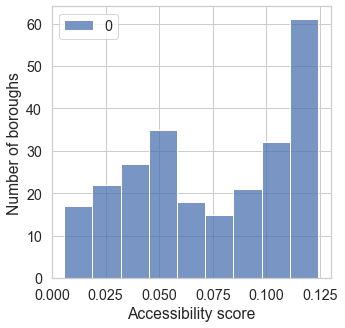

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))

ax = sns.histplot(A_i)
ax.set_xlabel("Accessibility score")
ax.set_ylabel("Number of boroughs")

plt.show()

In [14]:
# Save accessibility
pop_locations["A_i"] = A_i

# Accessibility Optimization

In [15]:
budget = 10000
growth_percentage = 0.2

## Regular Optimization

In [16]:
P_j = np.dot(P_i, W_ij)

c = W_ij.sum(axis=0) / P_j

A = [
    list(np.ones(c.shape[1]))
]

In [17]:
res = scipy.optimize.linprog(
    c=-c,
    A_ub=A,
    b_ub=[S_j.sum() + budget],
    bounds=[[s, (1 + growth_percentage) * s] for s in S_j[0]],
    method="revised simplex"
)

S_j_new_regular = res.x

In [18]:
# Compute new accessibility
R_j_new_regular = S_j_new_regular / np.dot(P_i, W_ij)
R_j_new_regular = np.nan_to_num(R_j_new_regular, 0)
A_i_new_regular = np.dot(W_ij, R_j_new_regular.T)

## Maxi-min optimization

In [19]:
# Define c
c = np.hstack([
    np.ones((1, 1)),
    np.zeros((1, S_j.shape[1]))
])

In [20]:
# Constraints for population locations
A_ub_1 = np.hstack([
    np.ones((P_i.shape[1], 1)),
    - W_ij / P_j
])

b_1 = np.dot(W_ij, (S_j / P_j).T)

In [21]:
# Constraints due to budget

A_ub_2 = np.hstack([
    np.zeros((1, 1)),
    np.ones((1, S_j.shape[1]))
])

b_2 = S_j.sum() + budget

In [22]:
# Boundaries

S_j_min = S_j
S_j_max = S_j * (1 + growth_percentage)

boundaries = np.vstack([
    np.asarray([[None], [None]]).T,  # no boundaries on z
    np.hstack([                      # 0 < x < 10% S_j
        S_j_min.T, 
        S_j_max.T
    ]) 
])

In [23]:
res = scipy.optimize.linprog(
    c=-c,
    A_ub=np.vstack([A_ub_1, A_ub_2]),
    b_ub=np.vstack([b_1, b_2]),
    method="revised simplex", 
    bounds=boundaries
)

S_j_new_maximin = res.x[1:]

In [24]:
# Compute new accessibility
R_j_new_maximin = S_j_new_maximin / np.dot(P_i, W_ij)
R_j_new_maximin = np.nan_to_num(R_j_new_maximin, 0)
A_i_new_maximin = np.dot(W_ij, R_j_new_maximin.T)

## Save results

In [25]:
# Regular optimization
pop_locations["A_i_new_regular"] = A_i_new_regular
pop_locations["A_i_delta_regular"] = pop_locations["A_i_new_regular"] - pop_locations["A_i"]

# Maximin optimization
pop_locations["A_i_new_maximin"] = A_i_new_maximin
pop_locations["A_i_delta_maximin"] = pop_locations["A_i_new_maximin"] - pop_locations["A_i"]

In [26]:
# Regular optimization
facilities["capacity_new_regular"] = S_j_new_regular
facilities["capacity_delta_regular"] = facilities["capacity_new_regular"] - facilities["capacity"]

# Maximin optimization
facilities["capacity_new_maximin"] = S_j_new_maximin
facilities["capacity_delta_maximin"] = facilities["capacity_new_maximin"] - facilities["capacity"]

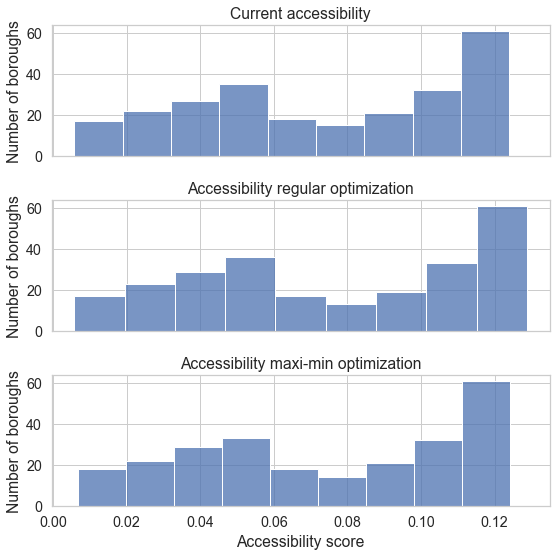

In [27]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(8, 8), sharex=True, sharey=True)

# Subplot 1
sns.histplot(
    data=pop_locations,
    x="A_i",
    ax=axs[0]
)

axs[0].set_title("Current accessibility")
axs[0].set_xlabel("Accessibility score")
axs[0].set_ylabel("Number of boroughs")

# Subplot 2
sns.histplot(
    data=pop_locations,
    x="A_i_new_regular",
    ax=axs[1]
)

axs[1].set_title("Accessibility regular optimization")
axs[1].set_xlabel("Accessibility score")
axs[1].set_ylabel("Number of boroughs")

# Subplot 3
sns.histplot(
    data=pop_locations,
    x="A_i_new_maximin",
    ax=axs[2]
)

axs[2].set_title("Accessibility maxi-min optimization")
axs[2].set_xlabel("Accessibility score")
axs[2].set_ylabel("Number of boroughs")

plt.tight_layout()
plt.show()

# Interactive map

In [28]:
# Init map
interactive_map = folium.Map(
    location=[40.7128, -74.0060],
    zoom_start=12,
    tiles="cartodbpositron"
)

# Add population
folium.Choropleth(
    name="Population density",
    show=False,
    geo_data=pop_locations[["ZIPCODE", "geometry"]].set_index("ZIPCODE"),
    data=pop_locations,
    columns=["ZIPCODE", "POPULATION_DENSITY"],
    key_on="feature.id",
    fill_color="YlGnBu",
    line_opacity=0.05,
    fill_opacity=0.5,
).add_to(interactive_map)

# Add accessibility, before optimization
folium.Choropleth(
    name="Accessibility score, before optimization",
    geo_data=pop_locations[["ZIPCODE", "geometry"]].set_index("ZIPCODE"),
    data=pop_locations,
    columns=["ZIPCODE", "A_i"],
    key_on="feature.id",
    fill_color="YlGn",
    line_opacity=0.05,
    fill_opacity=0.5,
).add_to(interactive_map)

# Add accessibility delta, after regular optimization
folium.Choropleth(
    name="Accessibility delta, after regular optimization",
    show=False,
    geo_data=pop_locations[["ZIPCODE", "geometry"]].set_index("ZIPCODE"),
    data=pop_locations,
    columns=["ZIPCODE", "A_i_delta_regular"],
    key_on="feature.id",
    fill_color="Purples",
    line_opacity=0.05,
    fill_opacity=0.5,
).add_to(interactive_map)

# Add accessibility delta, after maxi-min optimization
folium.Choropleth(
    name="Accessibility delta, after maxi-min optimization",
    show=False,
    geo_data=pop_locations[["ZIPCODE", "geometry"]].set_index("ZIPCODE"),
    data=pop_locations,
    columns=["ZIPCODE", "A_i_delta_maximin"],
    key_on="feature.id",
    fill_color="Purples",
    line_opacity=0.05,
    fill_opacity=0.5,
).add_to(interactive_map)

# Add facilities
for _, row in facilities.iterrows():   
    folium.Marker(
        name="Facilities",
        show=True,
        location=(row["Latitude"], row["Longitude"]),
        popup="{0} ({1})".format(
            row["DBA"],
            row["CUISINE DESCRIPTION"]
        ),
        icon=folium.DivIcon(html="""
            <div><svg>
                <rect width="{0}"
                      height="{0}"
                      fill="{1}"
                      opacity=".8"
                      stroke="black"
                      stroke-width=".5"
                />
            </svg></div>
            """.format(row["capacity"] / 100, "#fee6ce")
        )
    ).add_to(interactive_map)

# Add LayerControl
folium.LayerControl().add_to(interactive_map)
    
# Save map
interactive_map.save("/Users/eric/Desktop/map.html")

/usr/local/lib/python3.7/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
